## Purpose of this notebook

This notebook translates churn risk rankings into business decisions.
We simulate retention policies under capacity constraints by estimating
expected value (EV) for different intervention budgets and assumptions.

The goal is to determine:
- Which customers to target
- How many customers to target (capacity K)
- Whether and where expected value peaks under different policies

In [7]:
import boto3
import pandas as pd
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt

BUCKET = "online-retail-churn-siqi-dev"
REF_DATE = "2011-10-10"
SNAPSHOT_KEY = f"features/online_retail/dt=2026-01-12/customer_snapshot_ref={REF_DATE}.parquet"

session = boto3.Session(profile_name="siqi-dev")
s3 = session.client("s3")

obj = s3.get_object(Bucket=BUCKET, Key=SNAPSHOT_KEY)
df = pd.read_parquet(BytesIO(obj["Body"].read()), engine="pyarrow")

df.shape

(3013, 11)

In [8]:
# Risk score calculation
df = df.copy()

df["recency_rank"]   = df["recency_days"].rank(pct=True)
df["frequency_rank"] = 1 - df["frequency_180d"].rank(pct=True)
df["monetary_rank"]  = 1 - df["monetary_180d"].rank(pct=True)

df["risk_score"] = (
    0.5 * df["recency_rank"]
  + 0.25 * df["frequency_rank"]
  + 0.25 * df["monetary_rank"]
)

In [9]:
# Policy assumptions (simulation)
COST = 5.0          # € per intervention
UPLIFT = 0.10       # 10% reduction in churn probability
VALUE_COL = "monetary_180d"  # value proxy

# Us risk score as p_i
df["p_proxy"] = df["risk_score"]

# Expected Value
df["EV"] = df["p_proxy"] * UPLIFT * df[VALUE_COL] - COST

In [10]:
def cumulative_ev_curve(df, score_col="risk_score", ev_col="EV", ks=None):
    if ks is None:
        ks = [50, 100, 200, 300, 500, 800, 1000, 1500, 2000]

    d = df.sort_values(score_col, ascending=False).reset_index(drop=True)
    d["cum_EV"] = d[ev_col].cumsum()

    out = []
    for k in ks:
        if k <= len(d):
            out.append({"K": k, "cum_EV": d.loc[k-1, "cum_EV"]})
    return pd.DataFrame(out)

curve = cumulative_ev_curve(df)
curve

,K,cum_EV
0,50,228.702511
1,100,636.696196
2,200,1827.063557
3,300,3092.562365
4,500,6428.270513
5,800,14632.294653
6,1000,19352.110168
7,1500,34070.115593
8,2000,50176.227167


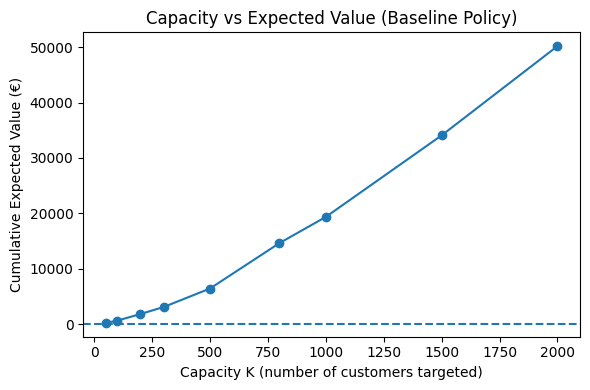

In [11]:
plt.figure(figsize=(6,4))
plt.plot(curve["K"], curve["cum_EV"], marker="o")
plt.axhline(0, linestyle="--")
plt.xlabel("Capacity K (number of customers targeted)")
plt.ylabel("Cumulative Expected Value (€)")
plt.title("Capacity vs Expected Value (Baseline Policy)")
plt.tight_layout()
plt.show()

In [14]:
# Value segmentation
df["value_segment"] = pd.qcut(
    df["monetary_180d"], q=3, labels=["low", "mid", "high"]
)

policy_table = {
    "low":  {"cost": 5.0,  "uplift": 0.05},
    "mid":  {"cost": 5.0,  "uplift": 0.10},
    "high": {"cost": 10.0, "uplift": 0.30},
}

def compute_ev_row(row):
    p = policy_table[row["value_segment"]]
    return row["p_proxy"] * p["uplift"] * row["monetary_180d"] - p["cost"]

df["EV_segmented"] = df.apply(compute_ev_row, axis=1)

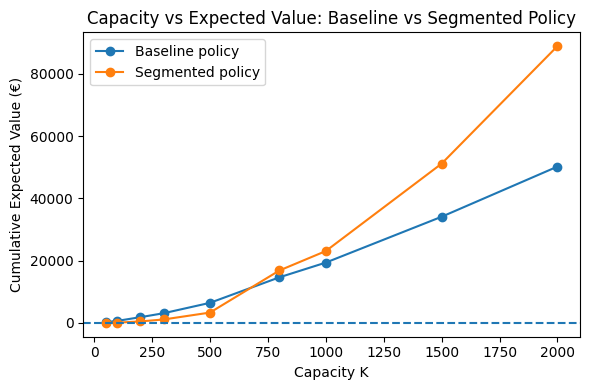

In [15]:
curve_seg = cumulative_ev_curve(df, ev_col="EV_segmented")

plt.figure(figsize=(6,4))
plt.plot(curve["K"], curve["cum_EV"], marker="o", label="Baseline policy")
plt.plot(curve_seg["K"], curve_seg["cum_EV"], marker="o", label="Segmented policy")
plt.axhline(0, linestyle="--")
plt.xlabel("Capacity K")
plt.ylabel("Cumulative Expected Value (€)")
plt.title("Capacity vs Expected Value: Baseline vs Segmented Policy")
plt.legend()
plt.tight_layout()
plt.show()

### Key Conclusion

- A uniform baseline policy performs well when operational capacity is limited.
- A segmented incentive policy provides higher expected value at larger capacities,
  where higher incentives can be focused on high-value customers.
- Policy effectiveness depends more on capacity and incentive design than on model
  complexity.

### Recommendation

- Use a baseline policy for small-scale retention actions.
- Use a segmented policy for larger campaigns where differentiated incentives are feasible.